# Language Analysis for WikiScraper

In [29]:
import json
import numpy as np
import wordfreq
import requests
import re
from collections import Counter
from wordfreq import top_n_list
from bs4 import BeautifulSoup
from wikiscraper.controller import Controller
from wikiscraper.scraper import Scraper
from wikiscraper.page import Page
from pathlib import Path
from wikiscraper import config


## lang_confidence_score 

In [22]:
def lang_confidence_score(word_counts: dict, language_words_with_frequency: dict) -> float:
    """
    Calculates a confidence score indicating how well the word_counts match a language.
    
    The score is calculated by taking the weighted sum of frequencies of the words 
    present in the text relative to the reference language distribution.
    
    Args:
        word_counts: A dictionary of {word: count} from the source text.
        language_words_with_frequency: A dictionary of {word: frequency} for the target language.
        
    Returns:
        float: A score between 0 and 1, where higher values indicate a better match.
    """
    if not word_counts or not language_words_with_frequency:
        return 0.0

    # Convert counts to relative frequencies (probabilities)
    words = list(word_counts.keys())
    counts = np.array([word_counts[w] for w in words], dtype=float)
    total = counts.sum()
    
    if total == 0:
        return 0.0
    
    text_probs = counts / total

    # Get reference frequencies for the words found in our text
    ref_probs = np.array([language_words_with_frequency.get(w, 0.0) for w in words], dtype=float)

    # Score calculation: Dot product of text distribution and language distribution
    raw_score = np.sum(text_probs * ref_probs) * 100

    # Apply sigmoid-like scaling to normalize the result between 0 and 1
    if raw_score == 0:
        return 0.0
        
    return float(raw_score)


In [23]:
import wordfreq

cl = Controller(clear_json=True)

languages = ['en', 'it', 'da']
k_values = [3, 10, 100, 1000]

lang_refs = {}

for lang in languages:
    full_freq_dict = wordfreq.get_frequency_dict(lang, wordlist='best')
    
    sorted_items = sorted(full_freq_dict.items(), key=lambda x: x[1], reverse=True)
    
    lang_refs[lang] = {}
    
    for k in k_values:
        lang_refs[lang][k] = dict(sorted_items[:k])



In [24]:
print(config.WORD_COUNTS_JSON)
cl.clear_cache()

/home/miki/UniProjects/Python/WikiScraper/data/word-counts.json


In [26]:
import json
from pathlib import Path

def get_score_of_page(data: dict[str,int], lang: str, k: int = 1000 ) -> float:
    """
    Counts words on a page and calculates its language confidence score
    using the pre-built lang_refs dictionary.
    """

    # Use the global lang_refs for reference frequencies
    return lang_confidence_score(data, lang_refs[lang][k])


def get_worst_page(start_page, lang: str, num: int = 50, k: int = 1000):
    """
    Iterates through pages to find the one that least matches the target language.
    
    Args:
        cl: Controller instance.
        start_page: Initial Page object.
        num: Maximum number of pages to check.
        
    Returns:
        tuple: (worst_page_object, lowest_score)
    """
    curr_page = start_page
    worst_page = start_page
    worst_score = float('inf')

    for _ in range(num):
        score = get_score_of_page(curr_page.get_dict(), lang, k)
        
        if score < worst_score:
            worst_score = score
            worst_page = curr_page
        
        curr_page = cl.next_page(curr_page, wait=0.5)
        if curr_page is None:
            break

    return worst_page, worst_score

## Data Prep

In [ ]:
pages = {}

# 1. Get Long Wiki Article (> 5000 words recommended)
long_wiki_page = cl._get_page("Team Rocket") 
pages["long_wiki_page"] = long_wiki_page.get_dict()
print(f"Long Wiki Page loaded: {long_wiki_page.phrase}")

# 2. Find the "Worst" Wiki Page (Minimum score over 50 iterations)
print("Searching for the 'worst' matching Wiki page (this may take a moment)...")
worst_page, worst_score = get_worst_page(long_wiki_page, 'en', num=3)
pages["worst_page"] = worst_page.get_dict()
print(f"Worst Wiki Page found: {worst_page} (Score: {worst_score:.4f})")



non_wiki_urls = {
    "en": "https://www.gutenberg.org/cache/epub/84/pg84-images.html",
    "de": "https://www.gutenberg.org/cache/epub/22367/pg22367-images.html",
    "it": "https://www.gutenberg.org/cache/epub/1232/pg1232-images.html"
}

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) Chrome/91.0.4472.124 Safari/537.36"
}

for lang, url in non_wiki_urls.items():
    try:
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()
        
        soup = BeautifulSoup(response.content, "html.parser")
        
        # Project Gutenberg keeps text in the body or <div> tags
        # This will grab all paragraph text which is where the story is
        paragraphs = soup.find_all('p')
        text_content = " ".join([p.get_text() for p in paragraphs])
        
        # Clean and count words
        words = re.findall(r'\w+', text_content.lower())
        
        # We only take the first 2000 words so the dictionary isn't huge
        word_counts = dict(Counter(words[:2000]))
        
        pages[f"non_wiki_{lang}"] = word_counts
        print(f"Success! Loaded {lang} (words counted: {len(words)})")
        
    except Exception as e:
        print(f"Failed to fetch {lang}: {e}")

print("\nData Preparation Complete.")
print(f"Keys in pages: {list(pages.keys())}")

Long Wiki Page loaded: Team_Rocket
Searching for the 'worst' matching Wiki page (this may take a moment)...
Worst Wiki Page found: <wikiscraper.page.Page object at 0x7b84c47a2840> (Score: 0.6254)
Success! Loaded en (words counted: 128145)
Success! Loaded it (words counted: 171477)
Success! Loaded de (words counted: 75941)

Data Preparation Complete.
Keys in pages: ['long_wiki_page', 'worst_page', 'non_wiki_en', 'non_wiki_it', 'non_wiki_de']


In [33]:
def compute_scores_table(pages, lang_refs):
    """
    Compute language confidence scores for multiple pages, languages, and k-values.
    
    Returns:
        data: dict[page_name][lang][k] = score
    """
    data = {}

    for page_name, page_dict in pages.items():
        data[page_name] = {}
        for lang in languages:
            data[page_name][lang] = {}
            for k in k_values:
                # Use only top-k words for this language
                score = get_score_of_page(data=page_dict, lang=lang, k=k)
                data[page_name][lang][k] = score

    return data


import matplotlib.pyplot as plt

def plot_scores(data):
    """
    Plot confidence scores for each page over different k-values.
    
    Args:
        data: dict[page_name][lang][k] = score
        languages: list of languages
        k_values: list of k
    """
    for page_name in data:
        plt.figure(figsize=(8, 5))
        for lang in languages:
            scores = [data[page_name][lang][k] for k in k_values]
            plt.plot(k_values, scores, marker='o', label=lang)
        
        plt.title(f"Language confidence scores for page '{page_name}'")
        plt.xlabel("Top-k words (k)")
        plt.ylabel("Confidence score")
        plt.xscale('log')
        plt.xticks(k_values, k_values)
        plt.legend(title="Language")
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.show()


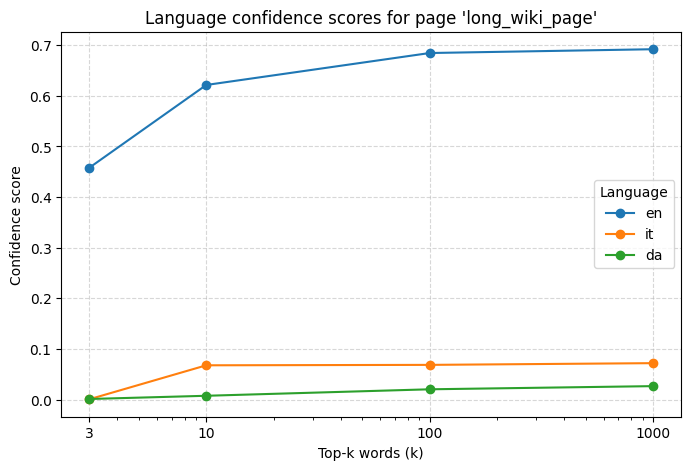

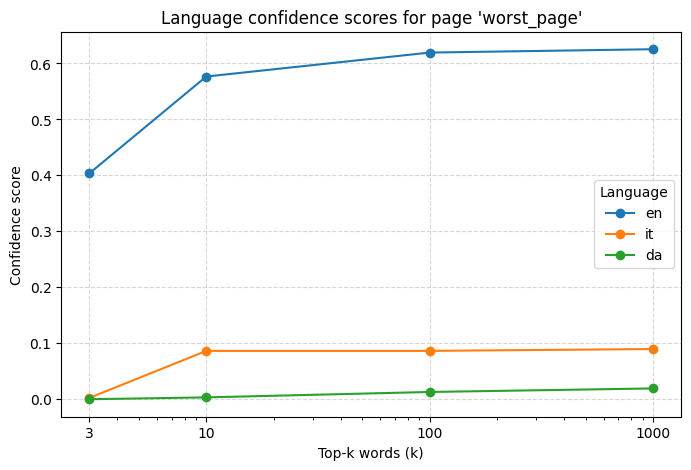

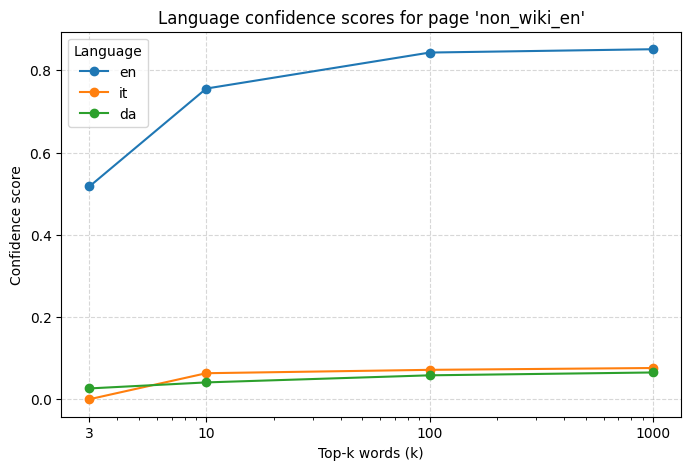

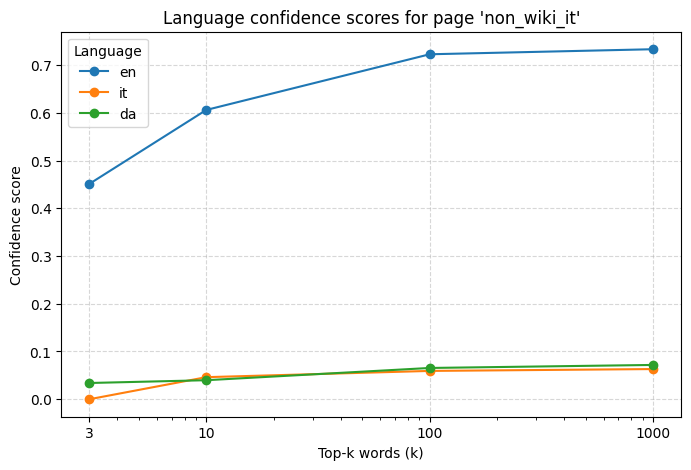

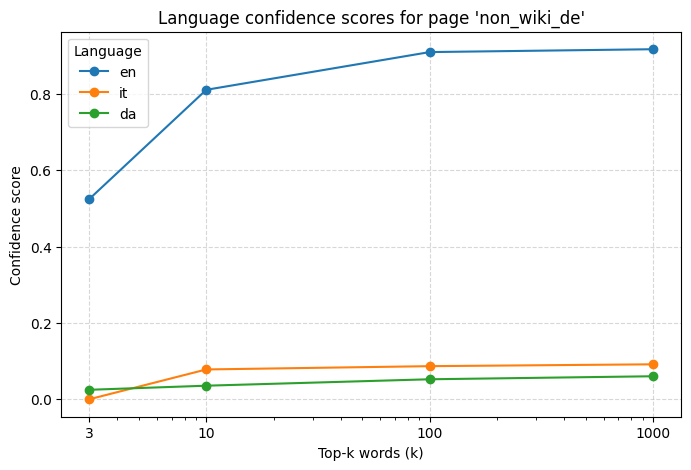

In [34]:
scores_data = compute_scores_table(pages, lang_refs)

plot_scores(scores_data)